# Craw Data for Classification Project
## Baktash Ansari

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## git

In [2]:
%cd /content/drive/MyDrive/NLP/Project/
!ls

/content/drive/MyDrive/NLP/Project
CrawDataNLProject  data  stats


## 1. Install library

In [ ]:
! pip install cinemagoer

# use NLTK for cleaning data
!pip install nltk

# for check spell :
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=fb0d83835e3c1ddf46ab51c2666723d6c96c4fd6d784bb1b0c4c953848e9ac12
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


## 2. Crawl *imdb id*

for download subtitles with need unique key for each movie and we use imdbid

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_imdb_ids(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    movie_links = soup.select('.lister-item-header a[href^="/title/"]')
    imdb_ids = [link['href'].split('/')[2] for link in movie_links]
    return imdb_ids
num_pages = 200
base_url = 'https://www.imdb.com/search/title/?title_type=feature&start='

all_imdb_ids = []
for page in range(1, num_pages + 1):
    start_index = (page - 1) * 50
    url = base_url + str(start_index)
    imdb_ids = get_imdb_ids(url)
    all_imdb_ids.extend(imdb_ids)

print("number of ids :",len(all_imdb_ids))

## 3. Download subtitle based on language and movie id

In [ ]:
import requests
from bs4 import BeautifulSoup

def gather_imdb_ids(url, count_limit):
    imdb_ids = []
    base_url = url
    count = 0

    page = 1
    while True:
        params = {
            "start": (page - 1) * 50 + 1
        }

        response = requests.get(base_url, params=params)
        soup = BeautifulSoup(response.content, "html.parser")

        movie_items = soup.select(".lister-item-header a")
        if not movie_items:
            break

        for item in movie_items:
            imdb_id = item["href"].split("/")[2]
            imdb_ids.append(imdb_id)
            count += 1

            if count == count_limit:
                return imdb_ids

        page += 1

    return imdb_ids

# Example usage
url = "https://www.imdb.com/search/title/?certificates="
rates = input("Enter the age ratings you want with space seperator").split()
srate = "US%3A"
for i,rate in enumerate(rates) :
  if i == len(rates) -1 :
    add_rate = srate + rate

  else :
    add_rate = srate + rate + ","
  url += add_rate

print(url)


count_limit = int(input("Enter the count limit for IMDb IDs: "))
specific_ids = gather_imdb_ids(url, count_limit)

print(f'Gathered {len(specific_ids)}')


Enter the age ratings you want with space seperatorPG PG-13 G
https://www.imdb.com/search/title/?certificates=US%3APG,US%3APG-13,US%3AG
Enter the count limit for IMDb IDs: 10000
Gathered 10000


In [ ]:
import requests
import json

def downSub(lang,imdbId,apiToken) :

  dir = "./subtitles/eng/"
  try :
    headers = {
      'Api-Key': apiToken,
      'Content-Type': 'application/json'
    }
    response = requests.post(f'https://api.opensubtitles.com/api/v1/subtitles?imdb_id={imdbId}&languages={lang}&order_by=ratings', headers=headers)
    if response.status_code == 200:
      response = response.json()
      if response["total_count"] > 0 :
        subid = response["data"][0]["attributes"]["files"][0]["file_id"]
        response2 = requests.post(f'https://api.opensubtitles.com/api/v1//download', headers=headers, json = {"file_id": subid})
        if response2.status_code == 200 :
          response2 = response2.json()
          url = response2["link"]
          subtitle = requests.get(url, allow_redirects=True)

          open(f'{dir}{imdbId}.txt', 'w').write(subtitle.text)

          return True



    return False

  except Exception as e:
    print(e)
    return False



In [ ]:
def top_250_movies() :
  ia = Cinemagoer()
  top_movies = ia.get_top250_movies()
  # Export IMDb IDs
  imdb_ids = ["tt" + str(movie.movieID) for movie in top_movies]
  return imdb_ids

In [ ]:
import json
import pickle
import time
from imdb import Cinemagoer, IMDbError
from collections import defaultdict
import os
import requests
import random
import time


%cd /content/drive/MyDrive/NLP/Project/data/raw


random.seed(time.time())

## your open subtitle account token
TOKENS = ['LDkM48z0z3vqC7cBt3P2P3v1bYqfp3hT', '7kVKJYjyBQZFvvE4lUnbKYl780N2oaEA',
          'MlHoSwyh94tp35Ekp8Uv1ky8HXIWDjLS', 'MI0ke5UYBsa46sZ3qktUsU2IJ05dLWnY',
          'kWfSPpPdQmR0HYaTZRWCGWGsDNMn5QM2', 'lvGFXoqn9CPwOgwsuCCULRPwmd5z31VF']

SUB_LANGUAGE = 'en'

# number of subtitle to download
NUMS = 400

# declare dict for labels :
Dictlabel = defaultdict(list)
# Already donwloaded subtitles :
downloadedSubs = []

# import labels :
# if os.path.exists("./labels.txt") :
#   with open("labels.txt", 'r') as labelFile :
#     for line in labelFile :

#     loaded_dict = json.load(labelFile)
#     Dictlabel.update(loaded_dict)

# import downloaded srts :
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Import downloaded subtitles~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
if os.path.exists("./sub_downloaded.txt") :
  with open("sub_downloaded.txt", 'r') as downloadedSub :
    lines = downloadedSub.readlines()
    for line in lines :
      downloadedSubs.append(line.split()[0])
print("Done")

try :
  with open("labels.txt", 'a') as file2 :
    with open("sub_downloaded.txt", 'a') as file3 :

      ia = Cinemagoer()
      # ids = all_imdb_ids
      ids = specific_ids
      random.shuffle(ids)
      indx = 0
      for id in ids :
        if indx == NUMS :
          print("finished")
          break
        if id in downloadedSubs :
          continue
        movieInfo = ia.get_movie(id.replace("tt", ""))
        ## export age rate of movie :
        if 'certificates' in movieInfo :
            for standard in movieInfo['certificates'] :
              if "United States" in standard and ("::" not in standard) and ("TV" not in standard) :
                label = standard.split("United States:")[1]
                # ["PG", "G", "NC-17", "R", "PG-13"]
                if label in ["PG", "G", "NC-17", "PG-13"]:
                  Dictlabel[id].append(label)
                  line = f'{id} {label} \n'
                  # download subtitle
                  if downSub(SUB_LANGUAGE, id, TOKENS[indx % len(TOKENS)]) :
                    file2.write(line)
                    file3.write(id + " \n")
                    downloadedSubs.append(id)
                    indx += 1
                    print(indx, line)
                    print("Subtitle successfully downloaded :) ")
                    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
                    time.sleep(1)
                    break
                  else :
                    print("Failed :(")
                    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

except Exception as e :
  print(e)



/content/drive/MyDrive/NLP/Project/data/raw
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Import downloaded subtitles~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done
Failed :(
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Failed :(
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


KeyboardInterrupt: ignored

## 4. Clean data :

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from autocorrect import Speller

spell = Speller(lang='en')

%cd /content/drive/MyDrive/NLP/Project/data/raw

def clean_subtitle(subtitle):


    # # Remove time stamps
    subtitle = re.sub(r'\d+:\d+:\d+,\d+ --> \d+:\d+:\d+,\d+\n', '', subtitle)

    # # Remove HTML tags
    subtitle = re.sub(r'<.*?>', '', subtitle)

    # # Remove URLs
    subtitle = re.sub(r'http\S+|www\S+', '', subtitle)

    # Remove numbers :
    subtitle = re.sub(r'\d+', '', subtitle)

    # sentence broken
    sentences = subtitle.split('\n\n')

    # remove \n in each sentence :
    for index, sentence in enumerate(sentences) :
      sentences[index] = sentence.replace('\n', ' ')
      sentences[index] = sentences[index].strip()

    # lower case :
    sentences = [" ".join([word.lower() for word in sentence.split()]) for sentence in sentences]

    # Removing Punctuation :
    sentences = [re.sub(r'[^\w\s]', '', sentence) for sentence in sentences]

    # strip :
    for index, sentence in enumerate(sentences) :

      sentence = sentence.strip()

      # word tokenize :
      words = word_tokenize(sentence)

      # remove remaining tokens that are not alphabetic
      words = [word for word in words if word.isalpha()]

      # filter out stop words
      stop_words = set(stopwords.words('english'))
      words = [w for w in words if not w in stop_words]


      # # stemming of words
      # porter = PorterStemmer()
      # words = [porter.stem(word) for word in words]

      # # check spell :
      # words = [spell(word) for word in words]
      sentences[index] = ' '.join(words)

    return '\n'.join(sentences)

with open(f"./subtitles/eng/tt0064645.txt", 'r') as subFile :
  print(clean_subtitle(subFile.read()))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/content/drive/MyDrive/NLP/Project/data/raw
come
austrian dragons streets vienna
drawn swords people
count tafe ordered police strict
fair strict people must learn
right arrest im slovenian im czech
czechs slovenes croatians hungarians
loyal subjects austrian emperor take trial
next
documents name
maurice ephraïm zeps surprise
newspaper editors police station
nothing surprising sir police state
first visit
occasion explain presence
student marches passing
inspector didnt see disorder
police soldiers arrive
way around demonstrations would happen much
youre insinuating
jew quotation new testament would unchristian
make available police future interrogations
naturally nothing hide
lucky wish could say
next documents dont
name
rudolf
rudolf make choice rudolf franz charles
documents would successful comedian
royal highness wanted please forgive
naturally forgive return forgive friends mine
releases immediately immediately royal highness
thanks
cold cold
cold
thanks
royal highness may enter

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def clean_subtitle2(subtitle):
    # Remove time stamps
    subtitle = re.sub(r'\d+:\d+:\d+,\d+ --> \d+:\d+:\d+,\d+\n', '', subtitle)

    # Remove HTML tags
    subtitle = re.sub(r'<.*?>', '', subtitle)

    # Remove URLs
    subtitle = re.sub(r'http\S+|www\S+', '', subtitle)

    # Remove sequence numbers

    subtitle = subtitle.split('\n')
    subList = []

    for line in subtitle :

      if  line.isdigit() :
        continue
      subList.append(line)

    subtitle = '\n'.join(subList)

    # Remove non-text characters
    subtitle = re.sub(r'[^\w\s]', ' ', subtitle)

    # Remove empty lines
    subtitle = '\n'.join(line for line in subtitle.split('\n') if line.strip())

    # lower :
    subtitle = subtitle.lower()

    subList = subtitle.split('\n')


    # remove first n lines of start and end
    n = 3
    subList = subList[n :]
    subList = subList[ : -n - 2]

    final_sentences = []

    for sentence in subList :
      if sentence == '' :
        continue
      final_sentences.append(sentence)

    # Create a translation table using the string module
    translator = str.maketrans('', '', string.punctuation)

    # Remove punctuation from each sentence in the list
    final_sentences = [sentence.translate(translator) for sentence in final_sentences]


    # sentences = sent_tokenize(subtitle)

    # for i in range(len(sentences)) :
    #   sentences[i] = sentences[i].replace('\n', ' ')
    #   sentences[i] = sentences[i].strip()
    #   # split into words
    #   tokens = word_tokenize(sentences[i])

    #   # convert to lower case
    #   tokens = [w.lower() for w in tokens]

    #   # remove punctuation from each word
    #   table = str.maketrans('', '', string.punctuation)
    #   stripped = [w.translate(table) for w in tokens]

    #   # remove remaining tokens that are not alphabetic
    #   words = [word for word in stripped if word.isalpha()]

    #   # filter out stop words

    #   stop_words = set(stopwords.words('english'))
    #   words = [w for w in words if not w in stop_words]

    #   sentences[i] = " ".join(words)

    # final_sentences = []

    # for sentence in sentences :
    #   if sentence == '' :
    #     continue
    #   final_sentences.append(sentence)

    sentences = '\n'.join(final_sentences)

    return sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Make clean Data :
Load subtitle txt file and save the relevant cleaned data in pickle file.

In [ ]:
import pickle
import os

%cd /content/drive/MyDrive/NLP/Project/data/raw

LANGUAGE = "eng"

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Cleaning Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")

files = os.listdir(f"./subtitles/{LANGUAGE}")
cleanedFiles = os.listdir(f"../clean/subtitles/{LANGUAGE}")

for file in files :
  if file == ".ipynb_checkpoints" :
    continue
  with open(f"./subtitles/{LANGUAGE}/{file}", 'r') as subFile :
    with open(f"../clean/subtitles/{LANGUAGE}/{file}", 'w') as cleanFile :
      cleanFile.write(clean_subtitle(subFile.read()))

with open(f"./labels.txt", 'r') as labelFile :
  with open(f"../clean/labels.txt", 'w') as cleanLabelFile :
    cleanLabelFile.write(labelFile.read())

with open(f"./sub_downloaded.txt", 'r') as subFile :
  with open(f"../clean/sub_downloaded.txt", 'w') as cleansubFile :
    cleansubFile.write(subFile.read())

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")

/content/drive/MyDrive/NLP/Project/data/raw
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Cleaning Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`


## 5. Sentence and word broken
make a data frame which has three columns :
+ List of sentences (or words)
+ Label
+ Imdb id

In [ ]:
from nltk.tokenize import word_tokenize
def sentence2word(sentences) :
  words = []
  for sentence in sentences :
    tokens = word_tokenize(sentence)
    words.extend(tokens)
  return words

In [ ]:
import os
import pandas as pd
%cd /content/drive/MyDrive/NLP/Project

LANGUAGE = "eng"


sentenceData = [] # [[imdb_id, [sentences], label], ... ]
wordData = [] # [[imdb_id, [words], label], ... ]

# import labels :
labelDict = dict()
if os.path.exists("./data/clean/labels.txt") :
  with open("./data/clean/labels.txt", 'r') as labelFile :
    for line in labelFile :
      line = line.split()
      labelDict[line[0]] = line[1]


print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Making DataFrame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")

files = os.listdir(f"./data/clean/subtitles/{LANGUAGE}")

for file in files :
  if file == ".ipynb_checkpoints" :
    continue
  with open(f"./data/clean/subtitles/{LANGUAGE}/{file}", 'r') as subFile :
    sentences = subFile.read().split('\n')
    sentenceData.append([file.split(".txt")[0], sentences, labelDict[file.split(".txt")[0]]])
    wordData.append([file.split(".txt")[0], sentence2word(sentences), labelDict[file.split(".txt")[0]]])

sentenceDf = pd.DataFrame(sentenceData, columns=['imdb_id', 'sentences', 'label'])
wordDf = pd.DataFrame(wordData, columns=['imdb_id', 'words', 'label'])

sentenceDf.to_csv('./data/sentencebroken/data.csv', index=False)
wordDf.to_csv('./data/wordbroken/data.csv', index=False)

print(sentenceDf)
print()
print(wordDf)

/content/drive/MyDrive/NLP/Project
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Making DataFrame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
         imdb_id                                          sentences  label
0      tt1078912  [house powers lights dead, little ones bunk be...     PG
1      tt0093693  [dock five immaculata, repeat, sit cesspool se...     PG
2      tt0076618  [rescue, oh rescue, rescue, im lost sea, witho...      G
3      tt0034583  [coming second world war, many eyes imprisoned...     PG
4      tt1028528  [hold got ta come, got ta take worlds biggest ...      R
...          ...                                                ...    ...
2045  tt12427158  [right mama, look well, okay, yes look nice, l...      R
2046   tt5095030  [still think night, mother leave, hopefully lo...  PG-13
2047   tt0089469  [lord darkness, require solace shadows, dark n...     PG
2048   tt0129387  [friends would say stop whinin theyve enough o...      R
2049   tt0327137  [yelling, hub lets roll, laugh ing, hub lo

## 6. Reports :

## Prepare data for making reports and make general report
+ save dict for data of each label ( label_data_dic.pickle ) ( [ [words] , [sentences] ] )
+ save dict for unique word of each label ( label_unique_data_dic.pickle )
+ save set of all unique words ( all_unique_words.pickle )
+ save csv for general report in stats

In [ ]:
import matplotlib.pyplot as plt

def generalPlot(data, name) :


  x_labels = [ "NC-17", "PG-13", "G", "R", "PG", "All"]
  y_values = data

  plt.figure(figsize=(10, 6))
  plt.bar(x_labels, y_values, color='blue')
  plt.xlabel("Features")
  plt.ylabel("Counts")
  plt.title(name)

  plt.savefig(f'./stats/{name}.png')  # Save the plot as a PNG file
  plt.show()
  print()


/content/drive/MyDrive/NLP/Project


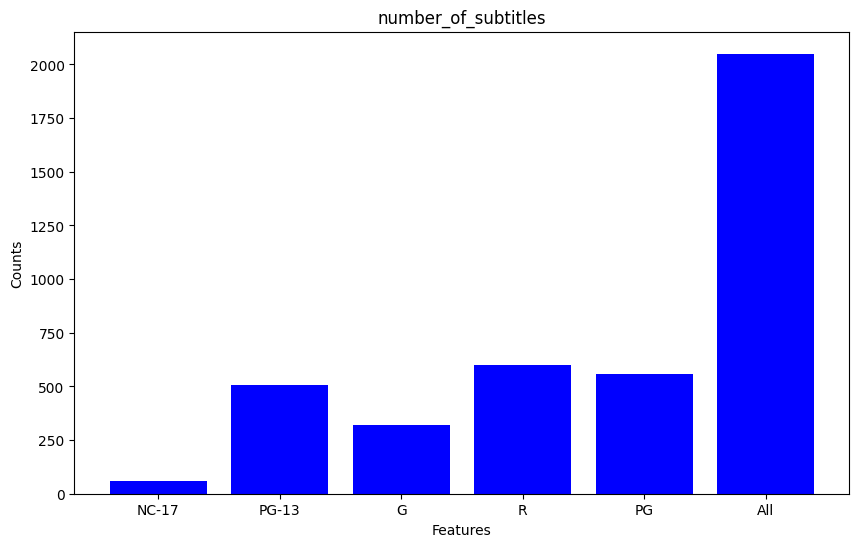

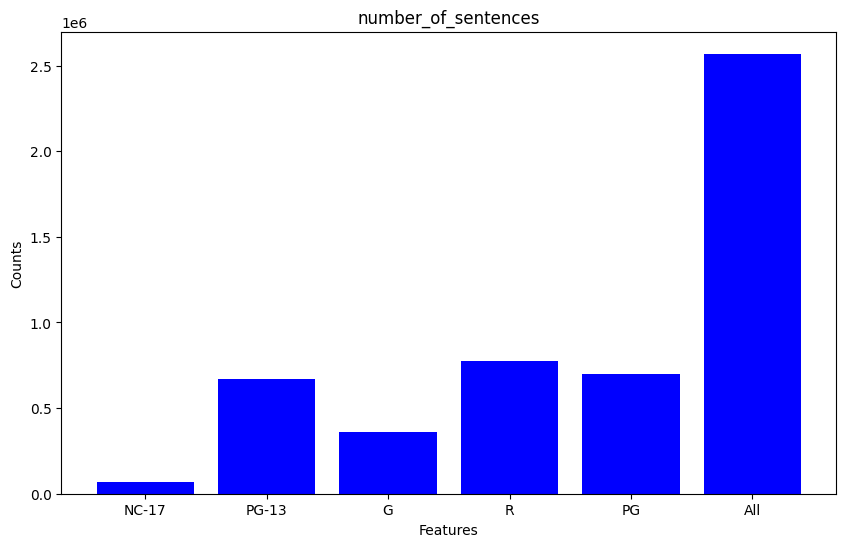

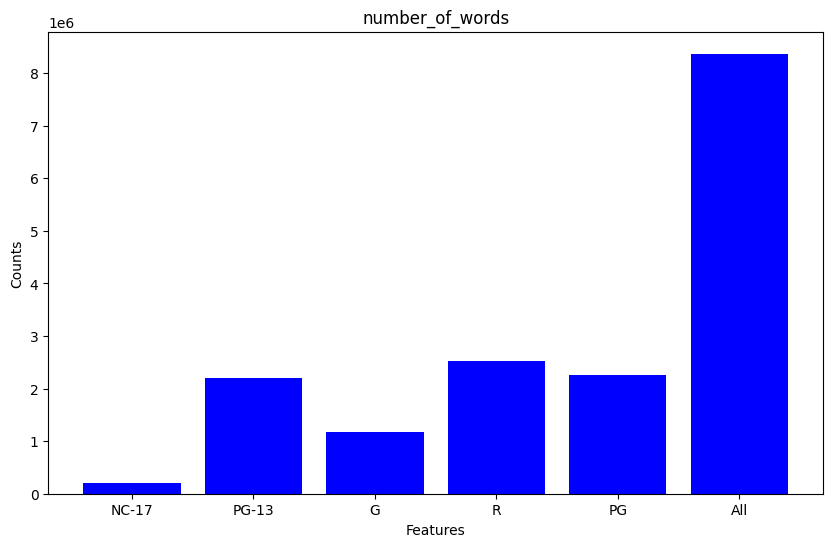

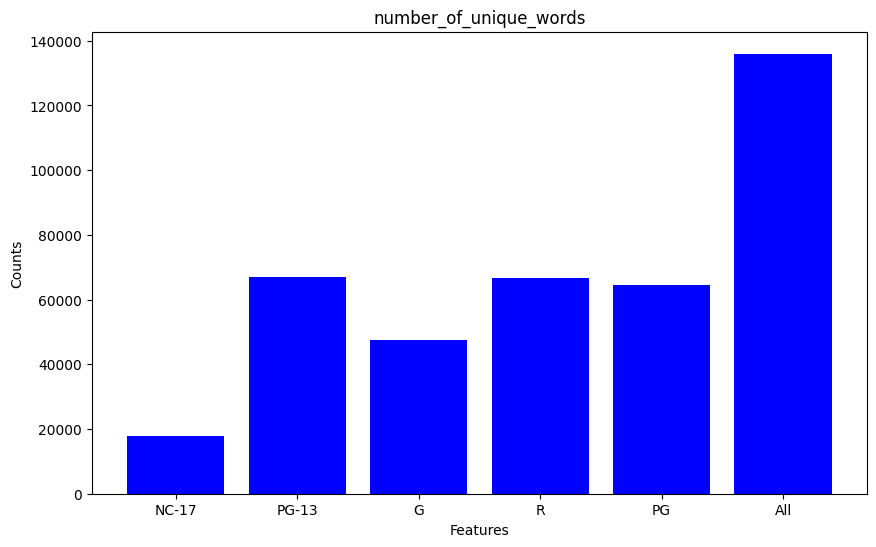

In [ ]:
import os
import pandas as pd
import pickle

%cd /content/drive/MyDrive/NLP/Project


def isUnique(word, label, withoutDuplicate) :
  # check if word of a label is unique or not
  for iterLabel in ['G', 'NC-17', 'PG', 'PG-13', 'R'] :
    if iterLabel == label :
      continue
    if word in withoutDuplicate[iterLabel] :
      return False
  return True


LANGUAGE = "eng"

# number of subtitle for each label :
subtitleLabels = {'G' : 0, 'NC-17' : 0, 'PG' : 0, 'PG-13' : 0, 'R' : 0}

# dict for data of each label :
labelsDict = {'G' : [[],[]], 'NC-17' : [[],[]], 'PG' : [[],[]], 'PG-13' : [[],[]], 'R' : [[],[]]} # [[words], [sentences]]

# dict for unique data of each label :
uniqueLabelsDict = {'G' : set(), 'NC-17' : set(), 'PG' : set(), 'PG-13' : set(), 'R' : set()}


# import labels :
labelDict = dict()
if os.path.exists("./data/clean/labels.txt") :
  with open("./data/clean/labels.txt", 'r') as labelFile :
    for line in labelFile :
      line = line.split()
      subtitleLabels[line[1]] += 1



# General Report :


# import sentence data frame
sentenceDf = pd.read_csv('./data/sentencebroken/data.csv')

# import word data frame
wordDf = pd.read_csv('./data/wordbroken/data.csv')

# number of data (subtitle) :
dataNum = sentenceDf.shape[0]

# number of sentences  :
sentenceDf['sentences'] = sentenceDf['sentences'].apply(lambda x: eval(x))
sentNum = sentenceDf['sentences'].apply(len).sum()


# number of all words :
wordDf['words'] = wordDf['words'].apply(lambda x: eval(x))
wordNum = wordDf['words'].apply(len).sum()


# number of all unique words :
uniqueWords = set()

for row in wordDf['words']:
    uniqueWords.update(row)

uniqueWordNum = len(uniqueWords)

# fill all words and sentences for each label
withoutDuplicate = {'G' : set(), 'NC-17' : set(), 'PG' : set(), 'PG-13' : set(), 'R' : set()}
for index, row in sentenceDf.iterrows():
  labelsDict[row["label"]][1].extend(row["sentences"])

for index, row in wordDf.iterrows():
  labelsDict[row["label"]][0].extend(row["words"])
  withoutDuplicate[row["label"]].update(row["words"])


# fill unique word of all label
for label in ["PG", "R", "G", "PG-13", "NC-17"] :
  wordList = list(withoutDuplicate[label])
  for word in  wordList :
    if isUnique(word, label, withoutDuplicate) :
      uniqueLabelsDict[label].add(word)

rows = [["All", dataNum, sentNum, wordNum, uniqueWordNum]]

for label in ["PG", "R", "G", "PG-13", "NC-17"] :
  labelRow = [label]

  # number of data (subtitle) :
  labelRow.append(subtitleLabels[label])

  # number of sentences  :
  labelRow.append(len(labelsDict[label][1]))


  # number of all words :
  labelRow.append(len(labelsDict[label][0]))

  # number of all unique words :
  labelRow.append(len(withoutDuplicate[label]))

  rows.insert(0,labelRow)


with open('./stats/label_data_dic.pickle', 'wb') as file :
  pickle.dump(labelsDict, file)
with open('./stats/all_unique_words.pickle', 'wb') as file :
  pickle.dump(uniqueWords, file)
with open('./stats/label_unique_data_dic.pickle', 'wb') as file :
  pickle.dump(uniqueLabelsDict, file)


generalDf = pd.DataFrame(rows, columns=['label','number of data', 'number of sentences', 'number of words', 'number of unique words'])
generalDf.to_csv('./stats/general_report.csv', index=False)

## plot for general report :
dataFig = []
nameFig = ['number_of_subtitles', 'number_of_sentences', 'number_of_words', 'number_of_unique_words']
for i in range(4) :
  row = []
  for item in rows :
    row.append(item[i+1])
  generalPlot(row, nameFig[i])



## Number of unique words that are common and non-common in every two labels :

In [ ]:
import os
import pandas as pd
import pickle
%cd /content/drive/MyDrive/NLP/Project

labels = ["PG", "R", "G", "PG-13", "NC-17"]


# load data of each label :
labelsDict = {}
with open('./stats/label_data_dic.pickle', 'rb') as file :
  labelsDict = pickle.load(file)


common_Df_list = []
non_common_Df_list = []
for i in range(5) :
  for j in range(i + 1, 5) :

    commonWordCount = set()
    nonCommonWordCount = set()
    label = f'{labels[i]}_{labels[j]}'
    firstSet = set(labelsDict[labels[i]][0])
    seccondSet = set(labelsDict[labels[j]][0])

    # for i-j label
    for word in firstSet :
      if word in seccondSet :
        commonWordCount.add(word)
      else :
        nonCommonWordCount.add(word)

    number_of_common_words = len(commonWordCount)
    number_of_non_common_words = len(nonCommonWordCount)

    common_Df_list.append([label, number_of_common_words])
    non_common_Df_list.append([label, number_of_non_common_words])

    commonWordCount = set()
    nonCommonWordCount = set()
    label = f'{labels[j]}/{labels[i]}'
    # for j-i label
    for word in seccondSet :
      if word in firstSet :
        commonWordCount.add(word)
      else :
        nonCommonWordCount.add(word)

    number_of_common_words = len(commonWordCount)
    number_of_non_common_words = len(nonCommonWordCount)

    common_Df_list.append([label, number_of_common_words])
    non_common_Df_list.append([label, number_of_non_common_words])

common_Df = pd.DataFrame(common_Df_list, columns=['Labels', "Number of common tokens"])
common_Df.to_csv('./stats/commonTokens.csv', index=False)

non_common_Df = pd.DataFrame(non_common_Df_list, columns=['Labels', "Number of non-common tokens"])
non_common_Df.to_csv('./stats/noncommonTokens.csv', index=False)
print(common_Df)
print(non_common_Df)

/content/drive/MyDrive/NLP/Project
         Labels  Number of common tokens
0          PG_R                    35246
1          R/PG                    35246
2          PG_G                    29358
3          G/PG                    29358
4      PG_PG-13                    35265
5      PG-13/PG                    35265
6      PG_NC-17                    14126
7      NC-17/PG                    14126
8           R_G                    28710
9           G/R                    28710
10      R_PG-13                    36056
11      PG-13/R                    36056
12      R_NC-17                    14289
13      NC-17/R                    14289
14      G_PG-13                    29108
15      PG-13/G                    29108
16      G_NC-17                    12872
17      NC-17/G                    12872
18  PG-13_NC-17                    14171
19  NC-17/PG-13                    14171
         Labels  Number of non-common tokens
0          PG_R                        29183
1          R/P

## 10 non-common words of each label :

/content/drive/MyDrive/NLP/Project


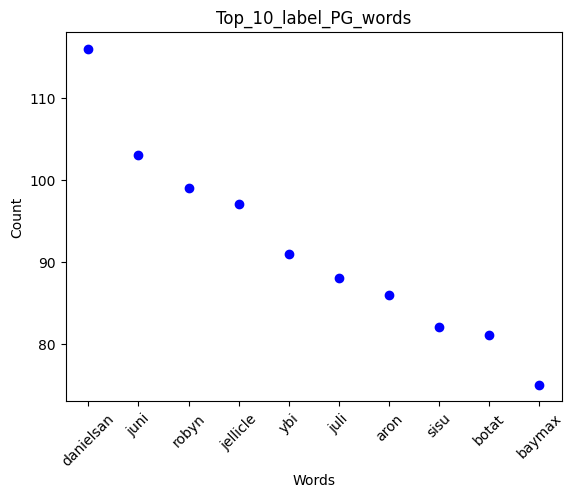

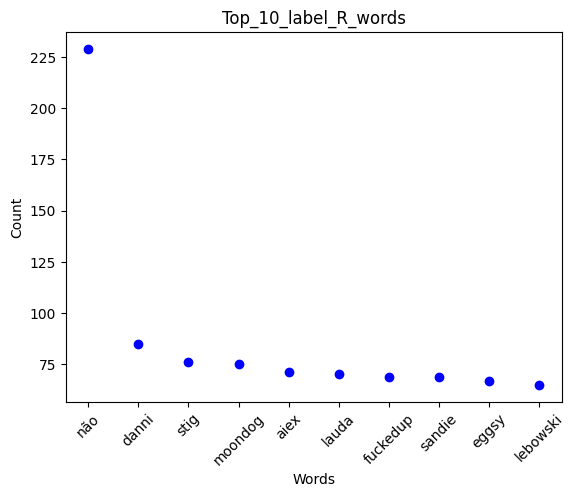

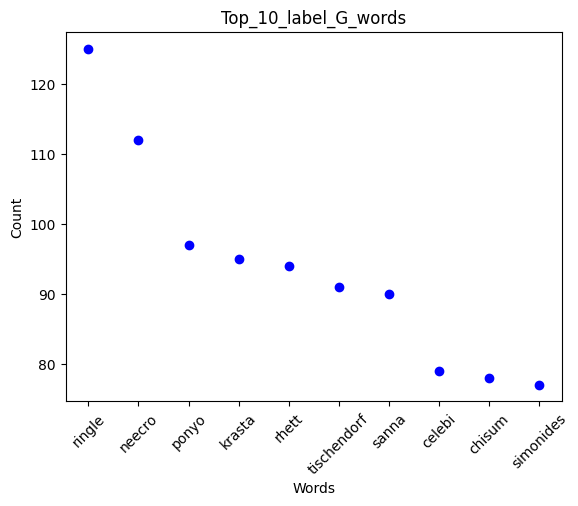

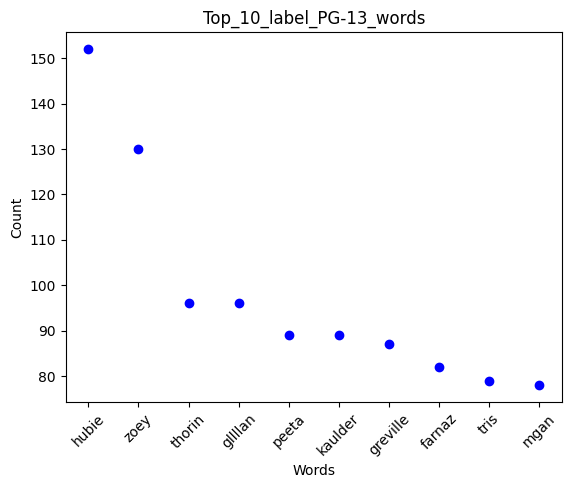

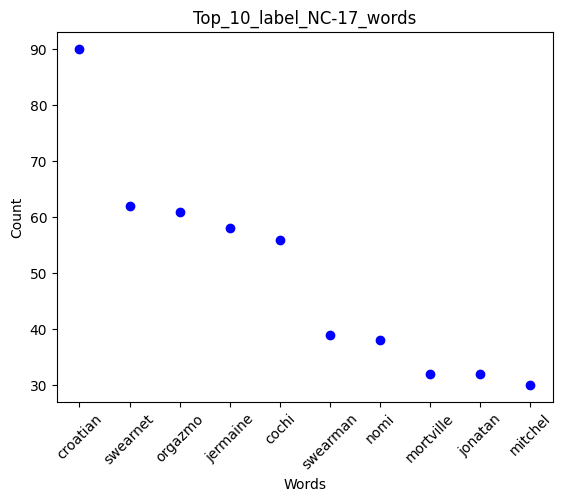

In [ ]:
import os
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt



%cd /content/drive/MyDrive/NLP/Project

# 10 non-common words of each label :

# load data and unique data of each label :

labelsDict = {}
with open('./stats/label_data_dic.pickle', 'rb') as file :
  labelsDict = pickle.load(file)

uniqueLabelsDict = {}
with open('./stats/label_unique_data_dic.pickle', 'rb') as file :
  uniqueLabelsDict = pickle.load(file)



for label in ["PG", "R", "G", "PG-13", "NC-17"] :

  # save number of each word in dictionary
  words_num = defaultdict(int)
  for word in labelsDict[label][0] :
    words_num[word] += 1

  # dict for each word and number of frequency
  label_frequency = {}
  for word in uniqueLabelsDict[label] :
    label_frequency[word] = words_num[word]

  sorted_items = sorted(label_frequency.items(), key=lambda x: x[1], reverse=True)
  top_10 = sorted_items[:10]

  keys = []
  values = []

  for tup in top_10:
      keys.append(tup[0])
      values.append(tup[1])

  plt.plot(keys, values, 'bo')

  plt.xlabel('Words')
  plt.ylabel('Count')
  plt.title(f'Top_10_label_{label}_words')

  plt.xticks(rotation=45)  # Rotate x-axis tick labels by 45 degrees

  plt.savefig(f'./stats/Top_10_label_{label}_words.png')  # Save the plot as a PNG file
  # Show the plot
  plt.show()

  print()



## The top 10 common words for each label compared to other labels based on the relative normalized frequency criterion.

/content/drive/MyDrive/NLP/Project


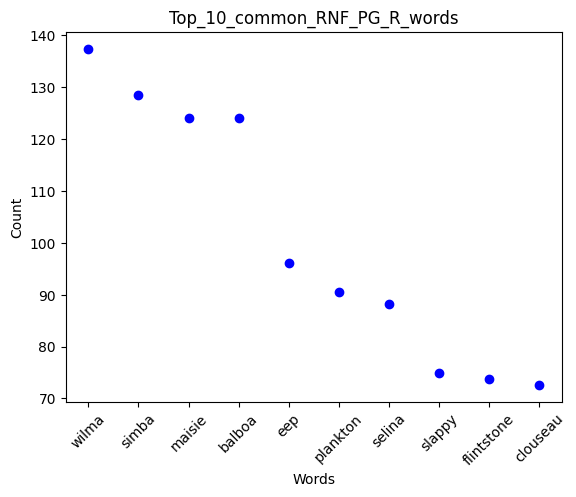

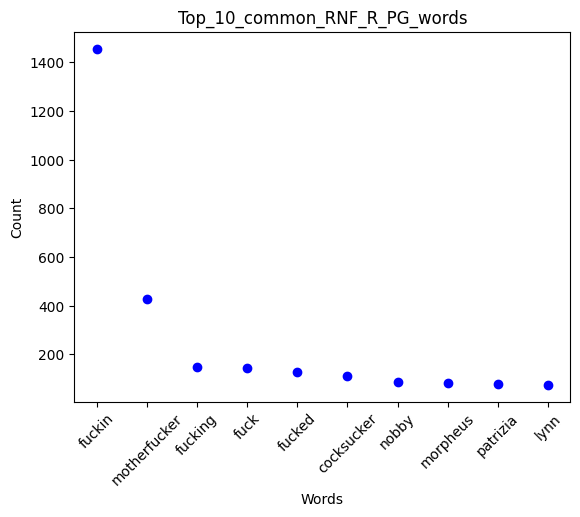

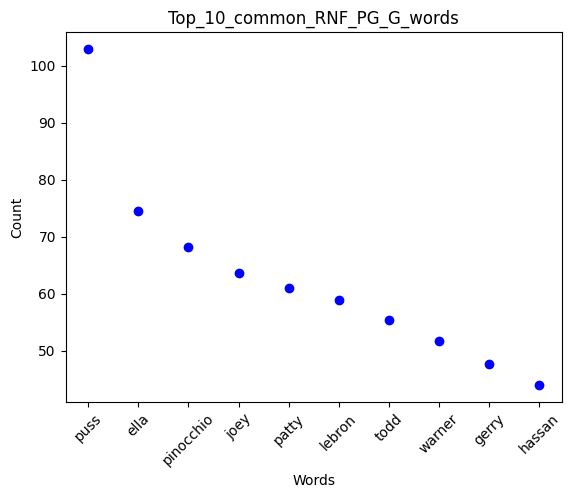

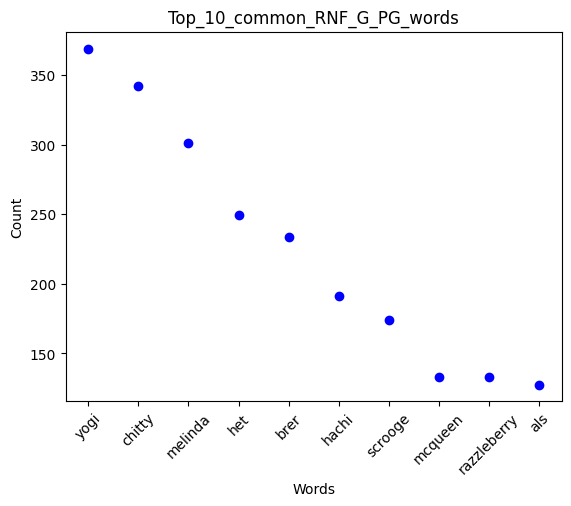

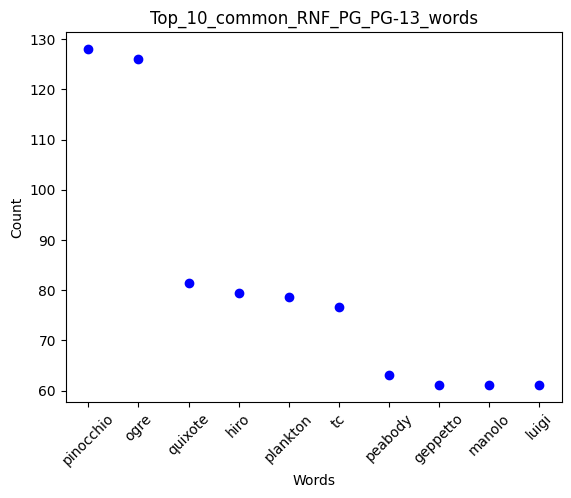

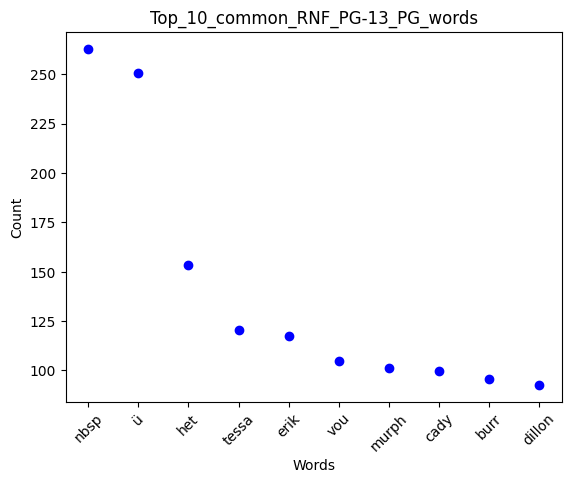

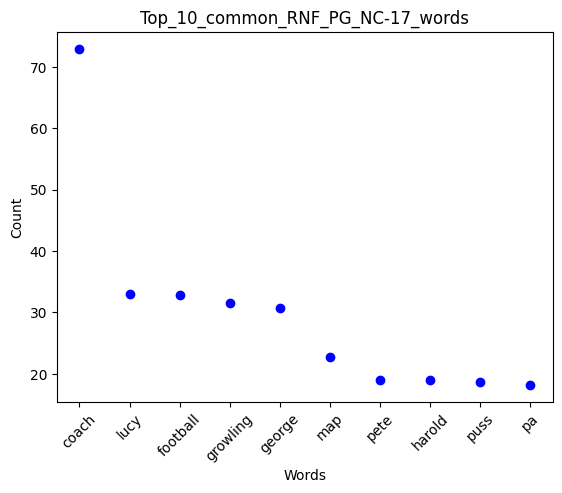

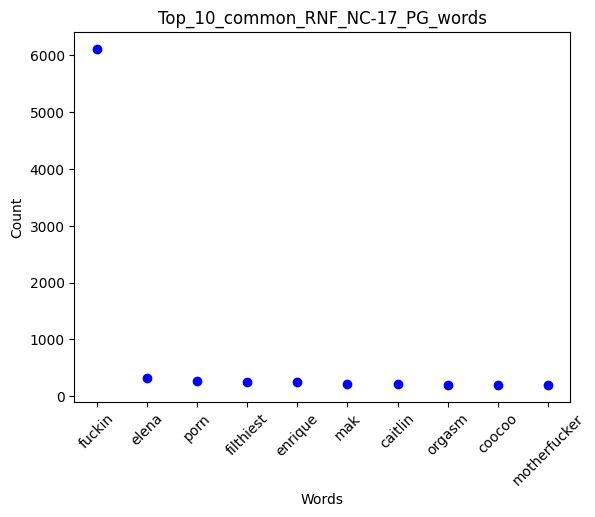

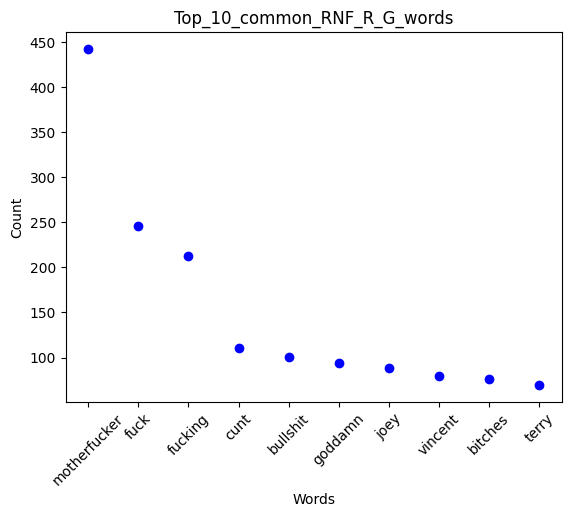

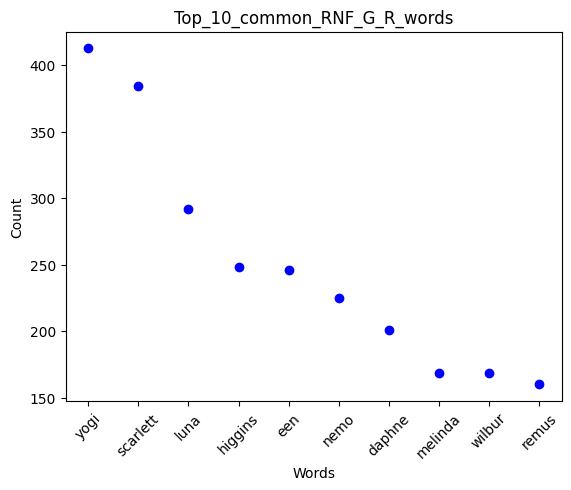

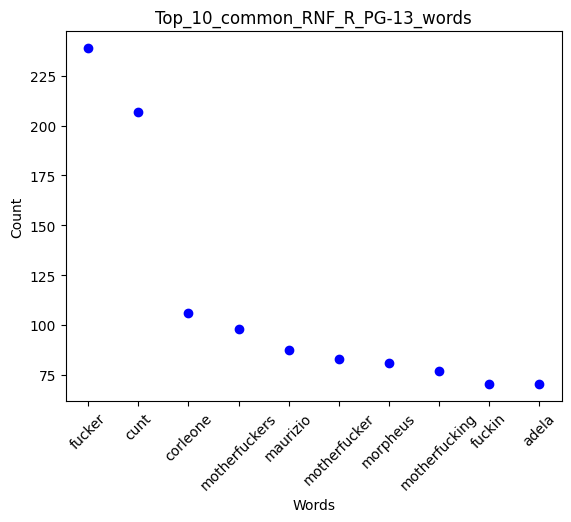

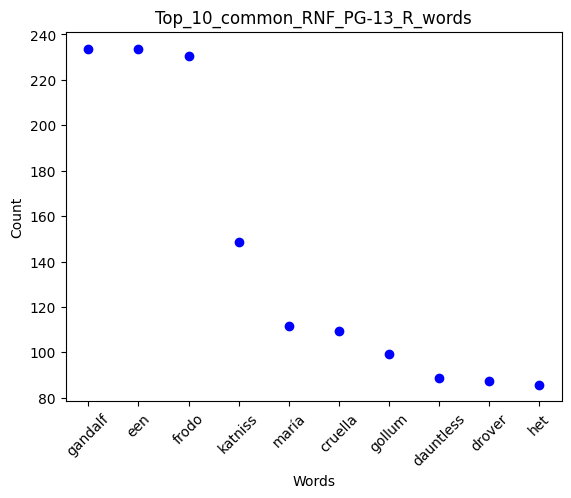

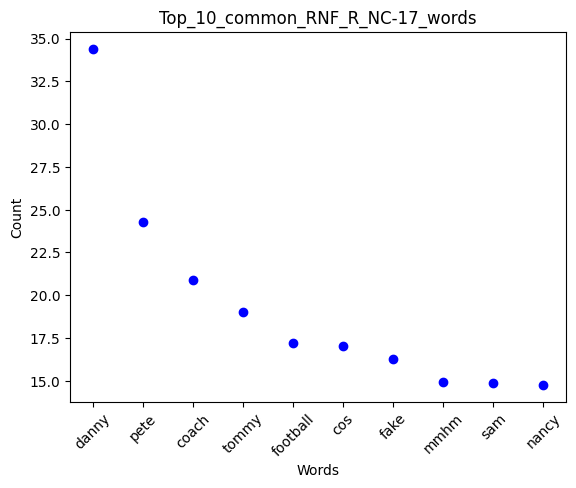

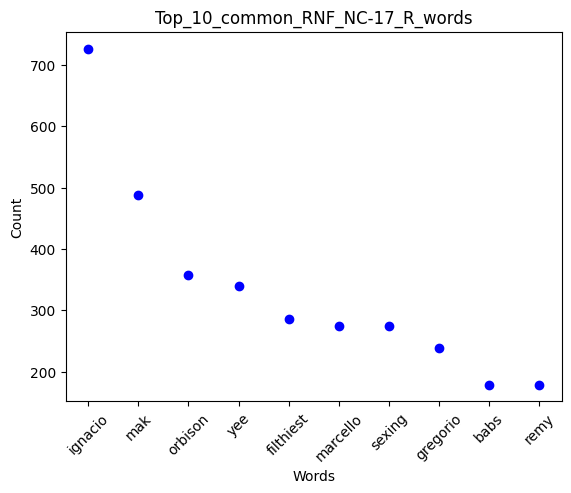

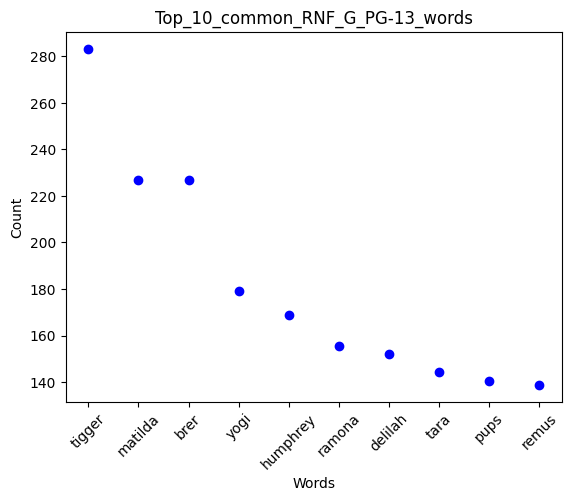

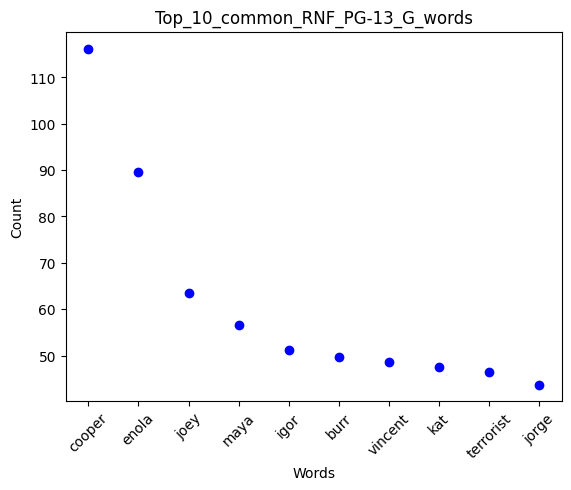

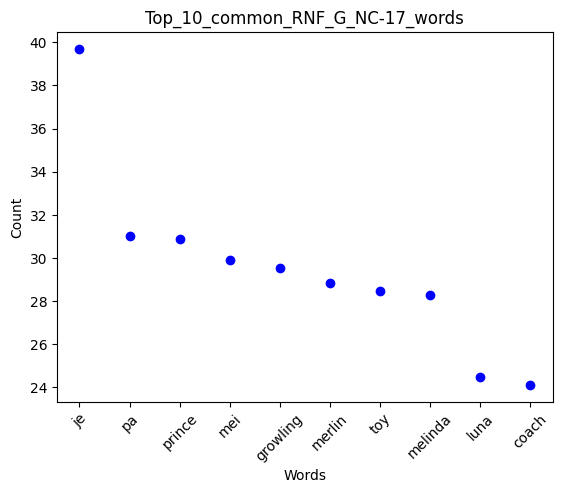

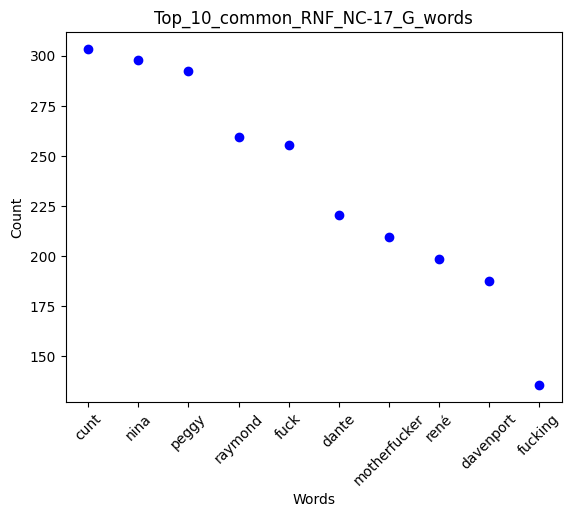

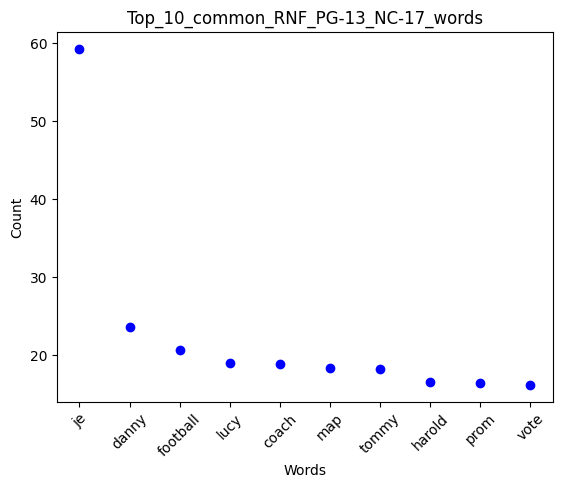

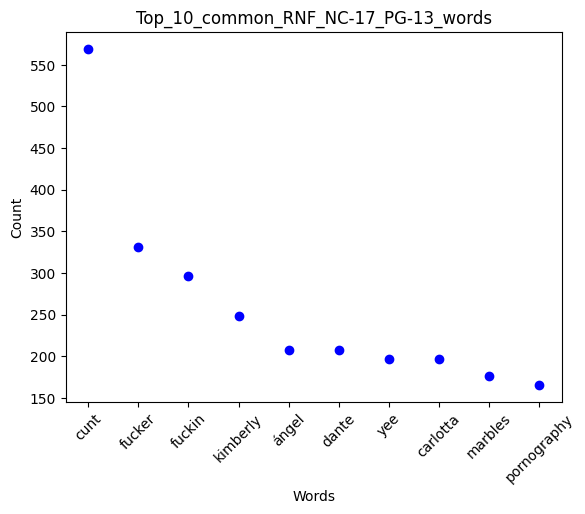

In [ ]:
import os
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

%cd /content/drive/MyDrive/NLP/Project

# load data  of each label :
labelsDict = {}
with open('./stats/label_data_dic.pickle', 'rb') as file :
  labelsDict = pickle.load(file)

# save non-duplicates words
nonDuplicated = {'G' : set(), 'NC-17' : set(), 'PG' : set(), 'PG-13' : set(), 'R' : set()}

# save number of each word in dictionary (for all words) and fill nonDuplicated
all_words_num = defaultdict(int)
for label in ["PG", "R", "G", "PG-13", "NC-17"] :
  nonDuplicated[label] = set(labelsDict[label][0])
  for word in labelsDict[label][0] :
    all_words_num[word] += 1


# save number of each word of each label
labelCountWords = {'G' : {}, 'NC-17' : {}, 'PG' : {}, 'PG-13' : {}, 'R' : {}}

for label in ["PG", "R", "G", "PG-13", "NC-17"] :
  # save number of each word in dictionary (for words in specific label)
  label_words_num = defaultdict(int)
  for word in labelsDict[label][0] :
    label_words_num[word] += 1
  labelCountWords[label] = label_words_num

labels = ["PG", "R", "G", "PG-13", "NC-17"]

for i in range(5) :
  for j in range(i + 1, 5) :

    # save words that they are common in 2 labels :
    commonWords = set()
    for word in all_words_num.keys() :
      if (word in nonDuplicated[labels[i]]) and (word in nonDuplicated[labels[j]]) :
        commonWords.add(word)

    # for i_j label
    # dictionary for save RNF of each word for this label
    rnfDic = {}
    for word in commonWords :
      RNF =  ( float(labelCountWords[labels[i]][word]) / len(labelsDict[labels[i]][0]) ) / ( float(labelCountWords[labels[j]][word]) / len(labelsDict[labels[j]][0]) )
      rnfDic[word] = RNF

    sorted_items = sorted(rnfDic.items(), key=lambda x: x[1], reverse=True)
    top_10 = sorted_items[:10]

    keys = []
    values = []

    for tup in top_10:
        keys.append(tup[0])
        values.append(tup[1])

    plt.plot(keys, values, 'bo')

    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title(f'Top_10_common_RNF_{labels[i]}_{labels[j]}_words')

    plt.xticks(rotation=45)  # Rotate x-axis tick labels by 45 degrees

    plt.savefig(f'./stats/Top_10_common_RNF_{labels[i]}_{labels[j]}_words.png')  # Save the plot as a PNG file
    # Show the plot
    plt.show()

    print()

    # for j_i label
    # dictionary for save RNF of each word for this label
    rnfDic = {}
    for word in commonWords :
      RNF =  ( float(labelCountWords[labels[j]][word]) / len(labelsDict[labels[j]][0]) ) / ( float(labelCountWords[labels[i]][word]) / len(labelsDict[labels[i]][0]) )
      rnfDic[word] = RNF

    sorted_items = sorted(rnfDic.items(), key=lambda x: x[1], reverse=True)
    top_10 = sorted_items[:10]

    keys = []
    values = []

    for tup in top_10:
        keys.append(tup[0])
        values.append(tup[1])

    plt.plot(keys, values, 'bo')

    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title(f'Top_10_common_RNF_{labels[j]}_{labels[i]}_words')

    plt.xticks(rotation=45)  # Rotate x-axis tick labels by 45 degrees

    plt.savefig(f'./stats/Top_10_common_RNF_{labels[j]}_{labels[i]}_words.png')  # Save the plot as a PNG file
    # Show the plot
    plt.show()

    print()



## Top 10 Words for each label based of TF-IDF

![TF](https://wikimedia.org/api/rest_v1/media/math/render/svg/dd4f8a91dd0d28a11c00c94a13a315a5b49a8070)

![IDF](https://wikimedia.org/api/rest_v1/media/math/render/svg/ac67bc0f76b5b8e31e842d6b7d28f8949dab7937)

![TF * IDF](https://wikimedia.org/api/rest_v1/media/math/render/svg/10109d0e60cc9d50a1ea2f189bac0ac29a030a00)

/content/drive/MyDrive/NLP/Project


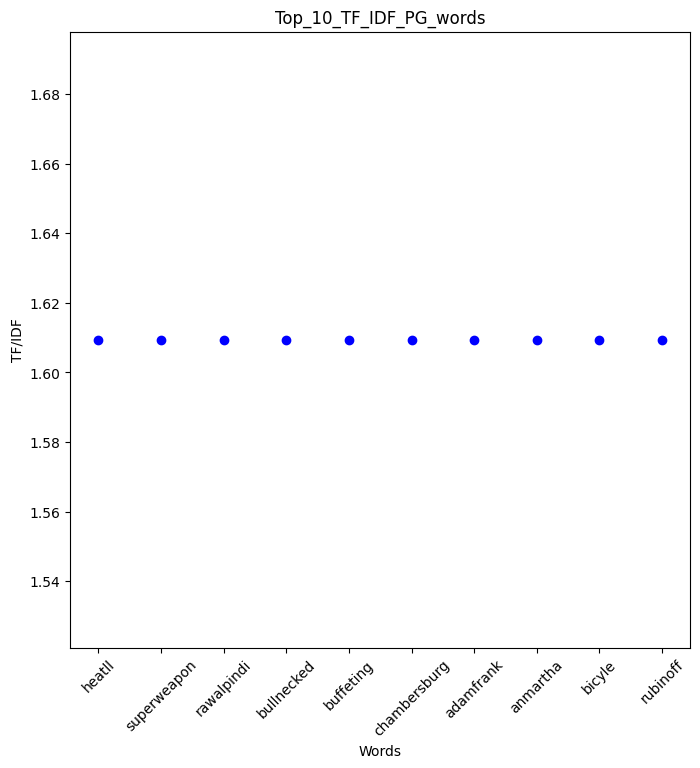

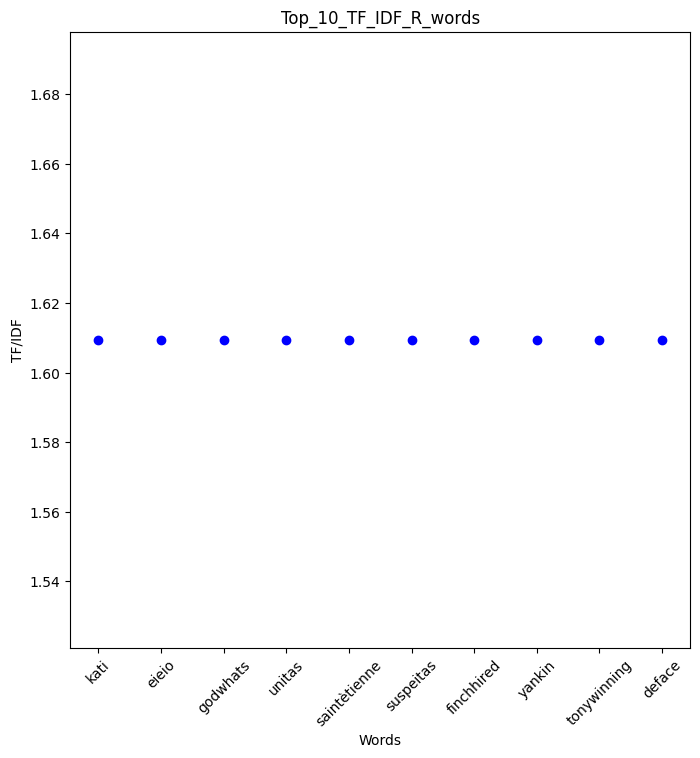

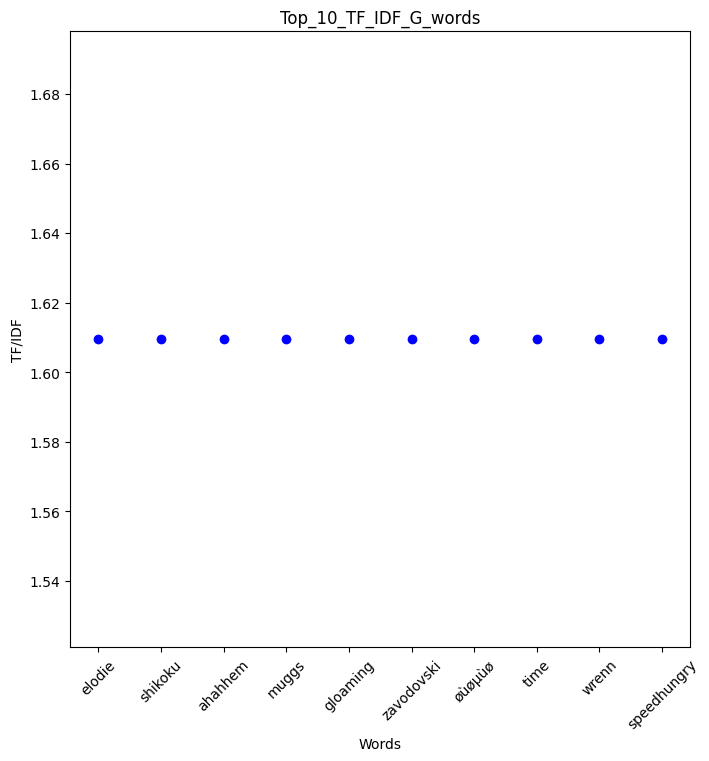

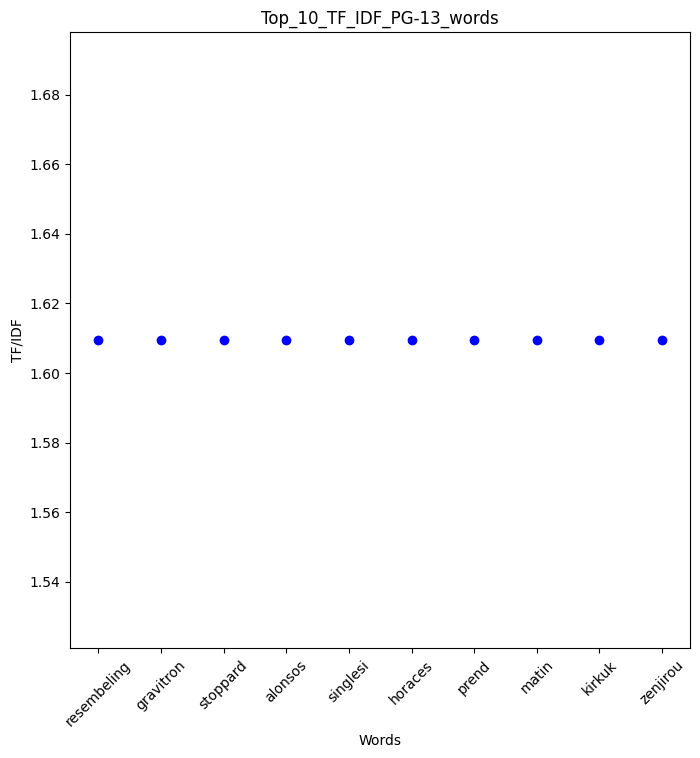

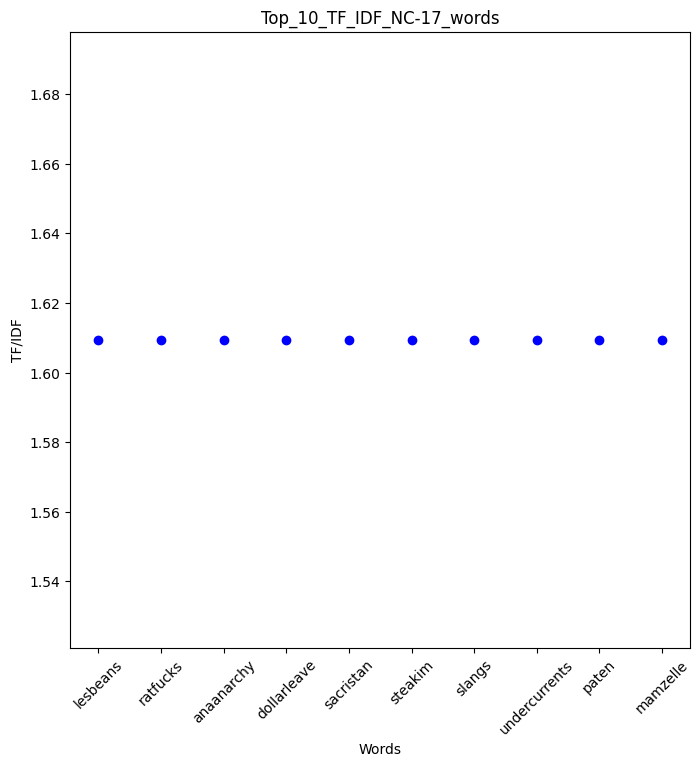

In [ ]:
import os
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import math

%cd /content/drive/MyDrive/NLP/Project

# load data of each label :
labelsDict = {}
with open('./stats/label_data_dic.pickle', 'rb') as file :
  labelsDict = pickle.load(file)

# save non-duplicates words
nonDuplicated = {'G' : set(), 'NC-17' : set(), 'PG' : set(), 'PG-13' : set(), 'R' : set()}

# save number of each word in dictionary (for all words) and fill nonDuplicated
all_words_num = defaultdict(int)
for label in ["PG", "R", "G", "PG-13", "NC-17"] :
  nonDuplicated[label] = set(labelsDict[label][0])
  for word in labelsDict[label][0] :
    all_words_num[word] += 1

# save number of labels which word appears on they :
wordLabelNum = defaultdict(int)
for word in list(all_words_num.keys()) :
  for label in ["PG", "R", "G", "PG-13", "NC-17"] :
    if word in nonDuplicated[label] :
      wordLabelNum[word] += 1

for label in ["PG", "R", "G", "PG-13", "NC-17"] :
  # save number of each word in dictionary (for words in specific label)
  label_words_num = defaultdict(int)
  for word in labelsDict[label][0] :
    label_words_num[word] += 1

  # calculate tf and idf :
  tfIdf = {}



  for word in list(nonDuplicated[label]) :
    tf = float( label_words_num[word] ) / all_words_num[word]
    idf = math.log ( 5.0 / wordLabelNum[word] )
    tfIdf[word] = tf * idf



  sorted_items = sorted(tfIdf.items(), key=lambda x: x[1], reverse=True)

  top_10 = sorted_items[:10]

  keys = []
  values = []

  for tup in top_10:
      keys.append(tup[0])
      values.append(tup[1])

  plt.figure(figsize=(8,8))

  plt.plot(keys, values, 'bo')

  plt.xlabel('Words')
  plt.ylabel('TF/IDF')
  plt.title(f'Top_10_TF_IDF_{label}_words')

  plt.xticks(rotation=45)  # Rotate x-axis tick labels by 45 degrees

  plt.savefig(f'./stats/Top_10_TF_IDF_{label}_words.png')  # Save the plot as a PNG file
  # Show the plot
  plt.show()

  print()


## Top 15 Words for each label histogram ( from high to low freq )



/content/drive/MyDrive/NLP/Project


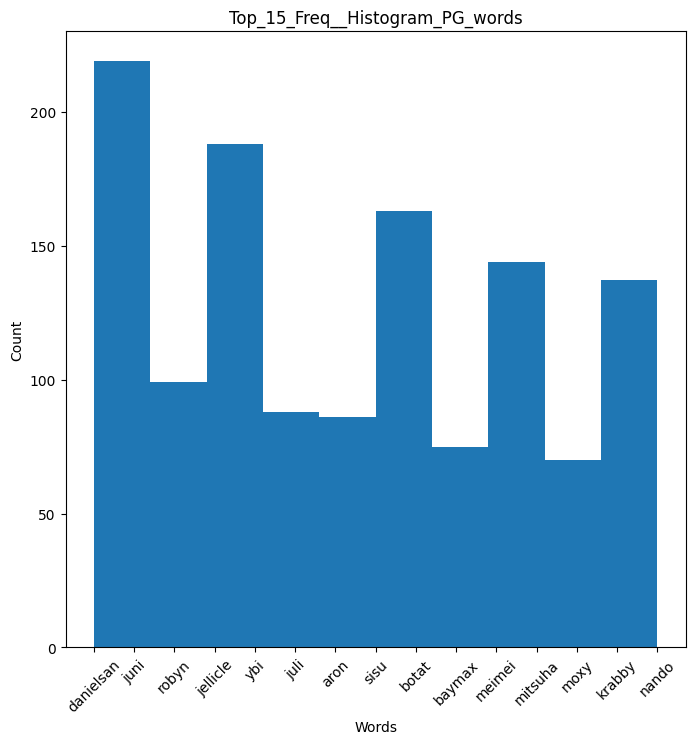

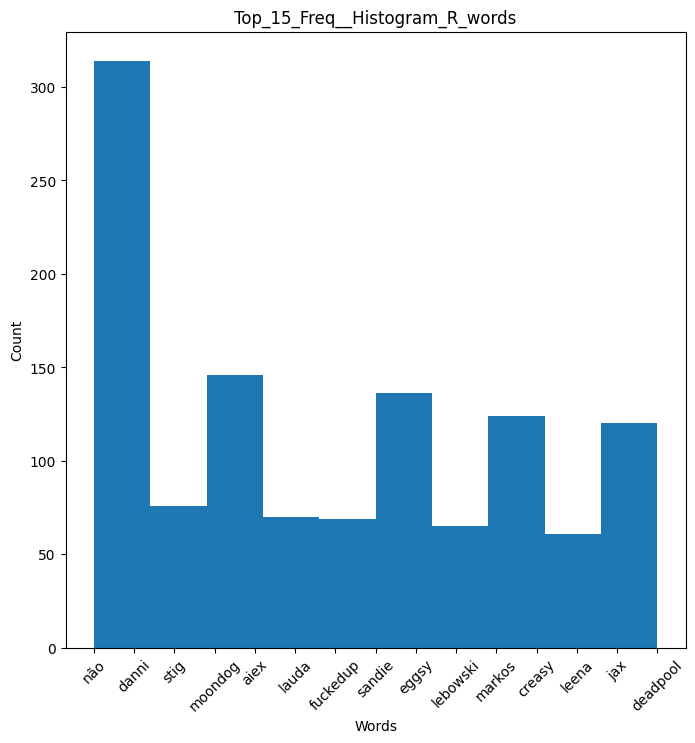

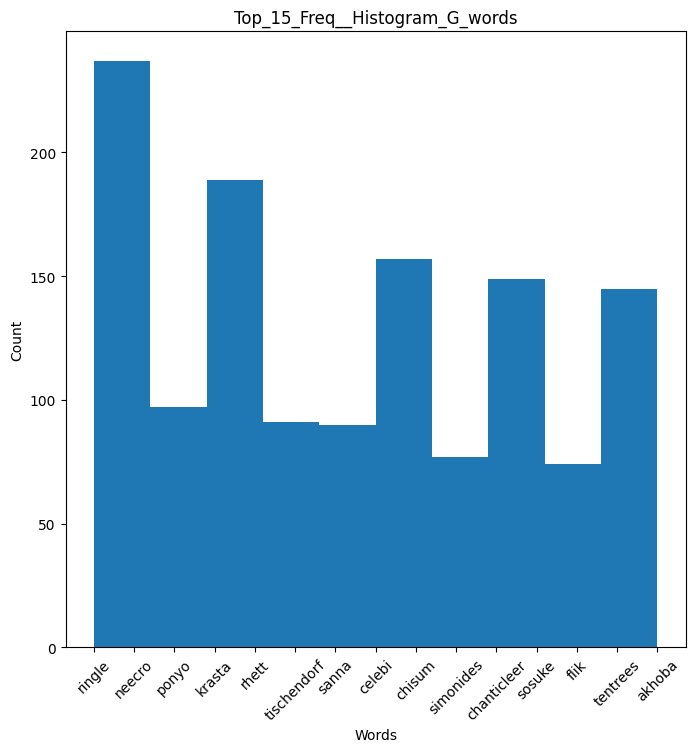

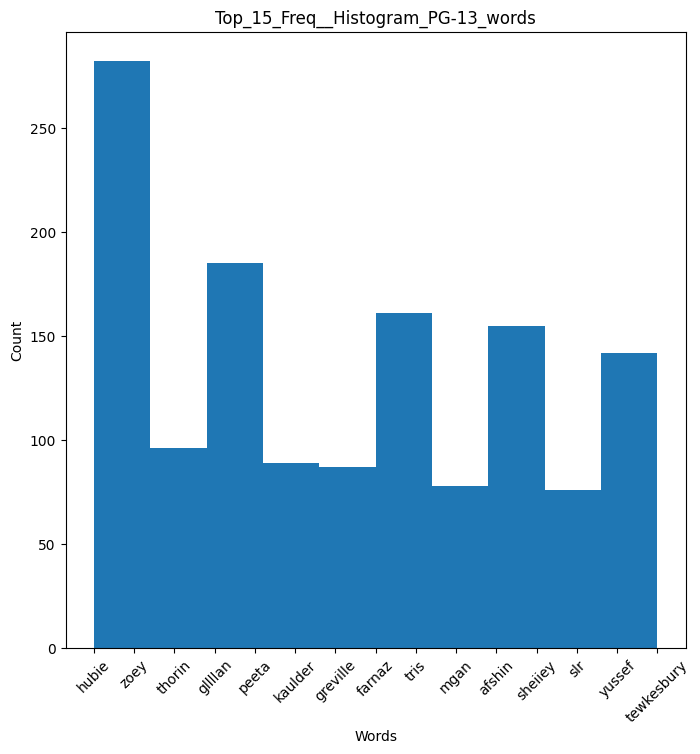

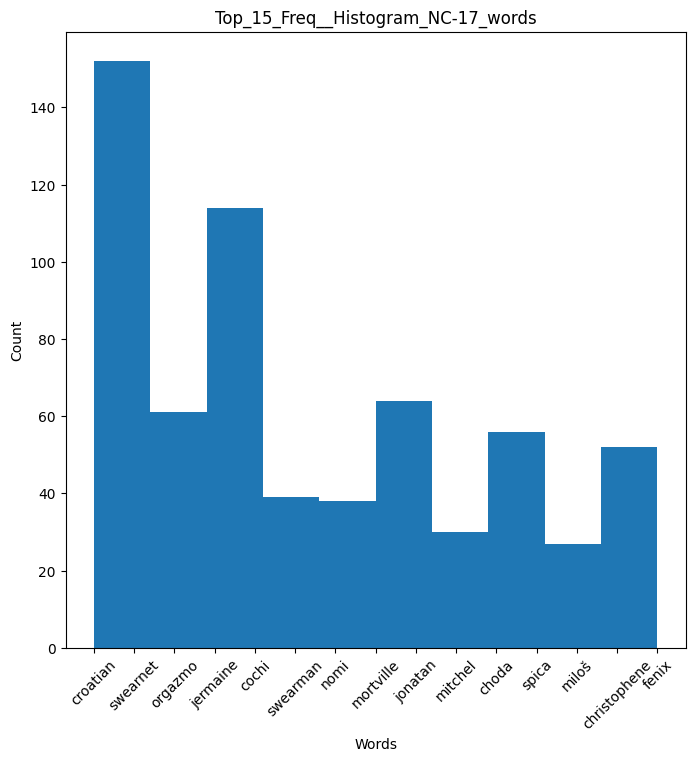

In [ ]:
import os
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import math

%cd /content/drive/MyDrive/NLP/Project

# load data of each label :
labelsDict = {}
with open('./stats/label_data_dic.pickle', 'rb') as file :
  labelsDict = pickle.load(file)


uniqueLabelsDict = {}
with open('./stats/label_unique_data_dic.pickle', 'rb') as file :
  uniqueLabelsDict = pickle.load(file)

for label in ["PG", "R", "G", "PG-13", "NC-17"] :
  # save number of each word in dictionary
  words_num = defaultdict(int)
  for word in labelsDict[label][0] :
    words_num[word] += 1

  # dict for each word and number of frequency
  label_frequency = {}
  for word in uniqueLabelsDict[label] :
    label_frequency[word] = words_num[word]

  sorted_items = sorted(label_frequency.items(), key=lambda x: x[1], reverse=True)
  top_15 = sorted_items[:15]

  hitData = []
  for key, value in top_15 :
    for i in range(value) :
      hitData.append(key)

  plt.figure(figsize=(8,8))

  plt.xlabel('Words')
  plt.ylabel('Count')
  plt.title(f'Top_15_Freq__Histogram_{label}_words')

  plt.hist(hitData)

  plt.xticks(rotation=45)

  plt.savefig(f'./stats/Top_15_Freq__Histogram_{label}_Words.png')  # Save the plot as a PNG file

  plt.show()

  print()



